In [1]:
# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
# from google.colab import drive
# drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/green' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (3, 2) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [3]:
width = 128
height = 128

# 주어진 폴더의 모든 파일을 numpy array로 변환하는 함수
def convertArray(path):
    file_list = os.listdir(path)
    img_X = [] # data
    img_Y = [] # target
    
    for i in range(len(file_list)): # 파일을 하나씩 읽음
        spt = os.path.splitext(file_list[i])
        # print(spt) # ('0', '.jpg')
        img_Y.append(int(spt[0])) # 파일명
        
#         img = Image.open(path + "/" + file_list[i])
#         img_array = np.array(img)
        image_bgr = cv2.imread(path + "/" + file_list[i], cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # 1차원 list안에 color 3차원 배열로 변경된 이미지를 저장     
        img_X.append(image_rgb) 

    img_X = np.array(img_X) # 이미지 데이터 [] -> ndarray
    img_Y = np.array(img_Y) # Target, Y

    
    # OpenCV는 흰색을 255로 나타냄으로 변환이 필요함.
    img_X = 255 - img_X # 색이 없으면 0으로 인식되게 변환, 255 - 4차원 배열
    
    # 텐서플로와 GPU 실수 기반에 최적화되어 있어
    # 0 ~ 1 사이의 실수 값으로 변경하면 정확도 상승, 정규화
    img_X = img_X / 255.0
    print('img_X: ', img_X.shape);
    
    # img_Y.reshape(img_Y.shape[0], 1): target은 2차원 배열의 형태이어야함.
    # 행수는 이미지 수, 컬럼이 1개인 2차원 배열
    # astype(int): 찾아야하는 값은 정수이기 때문에 형변환
    return img_X, img_Y.reshape(img_Y.shape[0], 1).astype(int)

In [4]:
# 데이터 준비
x_train, y_train = convertArray('./train') # 훈련용
x_val, y_val = convertArray('./val')       # 검증용
x_test, y_test = convertArray('./test')    # 테스트용 
# (70, 128, 128, 3): 칼라 이미지 70장, (count, width, height, color channel)

img_X:  (10, 128, 128, 3)
img_X:  (3, 128, 128, 3)
img_X:  (3, 128, 128, 3)


In [5]:
print(x_train.shape) # 훈련 데이터
print(y_train.shape) # (70, 1), 녹초 수치, 정수형

print(x_val.shape)   # 검증데이터
print(y_val.shape) 

print(x_test.shape)  # 테스트데이터
print(y_test.shape)
print(y_test)

(10, 128, 128, 3)
(10, 1)
(3, 128, 128, 3)
(3, 1)
(3, 128, 128, 3)
(3, 1)
[[10]
 [12]
 [ 6]]


In [6]:
print(type(x_train[0, 0, 0, 0])) # 첫번째 이미지 첫번째 픽셀의 type 확인
print(x_train[0:1]) # 첫번째 이미지 배열 값

<class 'numpy.float64'>
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


In [7]:
print(y_train[0:10]) # 훈련 target 확인

[[ 1]
 [10]
 [13]
 [14]
 [ 2]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 9]]


In [8]:
 # (None, 128, 128, 128)     3584: 128 x 128 이미지, 128 channel
# 3584: 필터_size * 필터 갯수 * color 수 + Bias 수
print(9 * 128 * 3 + 128)

3584


In [9]:
# 네트워크 구성
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

width=128
height=128

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), padding='same',
                 input_shape = (height, width,  3), activation='relu'))
model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(1)) # 활성화 함수 생략시 수치 예측(회귀 산출)
model.compile(optimizer=Adam(lr=0.00001), loss='mse')

model.summary()

# mcp = ModelCheckpoint(filepath='./Green.h5', monitor='val_accuracy',
#                       verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                 shuffle=True, epochs=1000, 
                 batch_size=1, callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# patience=5
# i5 2320: 181s, i5 8500 6core: 90s, i9-10900kf: i9-11900H 42s,
# Ryzen 7 2700X: , Ryzen 5 5600u: 35s, Ryzen 5 3600: 29s
# RTX 3090: 4.68s, RTX 2080: 5.57s, GTX 1060: 30s, Colab GPU: 20~33s
# loss: 10898.1055 - val_loss: 214.2879
# loss: 10898.1055 - val_loss: 214.2879
# loss: 10898.1055 - val_loss: 214.2879 23.36s

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 flatten (Flatten)           (None, 2097152)           0         
                                                                 
 dense (Dense)               (None, 1)                 2097153   
                                                                 
Total params: 2,100,737
Trainable params: 2,100,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000


10/10 [==============================] - 1s 43ms/step - loss: 62.2188 - val_loss: 52.5145
Epoch 2/1000
10/10 [==============================] - 0s 28ms/step - loss: 52.0071 - val_loss: 43.2801
Epoch 3/1000
10/10 [==============================] - 0s 29ms/step - loss: 41.2873 - val_loss: 35.2488
Epoch 4/1000
10/10 [==============================] - 0s 28ms/step - loss: 33.7880 - val_loss: 26.7597
Epoch 5/1000
10/10 [==============================] - 0s 28ms/step - loss: 25.0666 - val_loss: 19.5915
Epoch 6/1000
10/10 [==============================] - 0s 25ms/step - loss: 18.1680 - val_loss: 13.3369
Epoch 7/1000
10/10 [==============================] - 0s 30ms/step - loss: 11.6792 - val_loss: 8.8227
Epoch 8/1000
10/10 [==============================] - 0s 27ms/step - loss: 7.5848 - val_loss: 5.2825
Epoch 9/1000
10/10 [==============================] - 0s 27ms/step - loss: 4.4821 - val_loss: 2.9642
Epoch 10/1000
10/10 [==============================] - 0s 30ms/step - loss: 2.9043 - val_lo

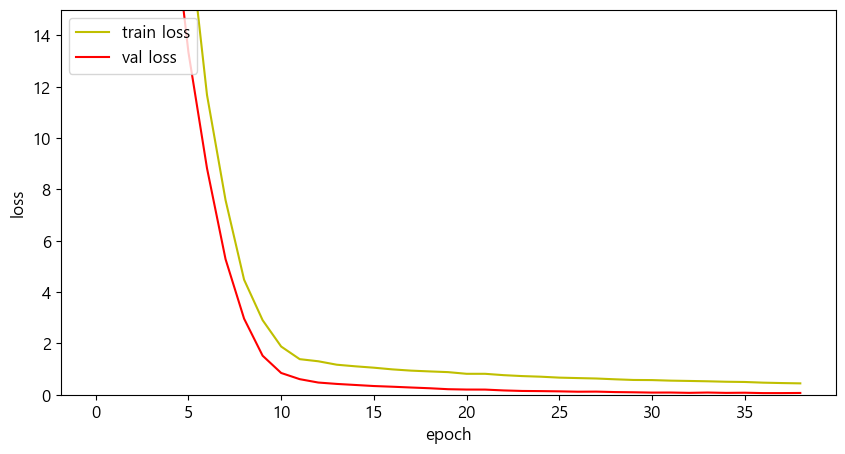

In [10]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 15]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
# acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
# acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
# acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
# acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [11]:
yp = model.predict(x_test, batch_size=1) # 모델 사용
print(yp)

[[10.27508  ]
 [12.001985 ]
 [ 5.0128407]]


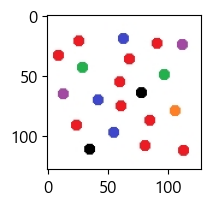

In [12]:
# 테스트할 첫번째 이미지 확인
file_list = os.listdir('./test')
img_bgr = cv2.imread('./test' + "/" + file_list[0], cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb);

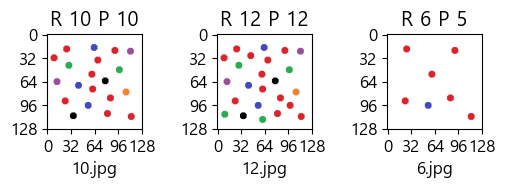

In [13]:
import glob # 파일 필터링

# fig.set_size_inches(16, 5)  # 챠트 크기 설정 
plt.rcParams["figure.figsize"] = (10, 4) # subplot 크기 결정
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
fig.tight_layout() # 최적의 간격 설정
rows = 1           # 1행 4열 이미지 출력
cols = 5
i = 1

# left - 왼쪽 margin. 디폴트는 0.125
# right - 오른쪽 margin. 디폴트는 0.9
# bottom - 아래쪽 margin. 디폴트는 0.1
# top - 위쪽 margin. 디폴트는 0.9
# wspace - subplots 의 수평 간격. 디폴트는 0.2
# hspace - subplots 의 수직 간격. 디폴트는 0.2
plt.subplots_adjust(wspace=0.8, hspace=0.4)

# 디렉터리 위치 변경
os.chdir('./test') 

for filename in glob.glob("*.jpg"): # jpg 파일만 추출
    img_bgr = cv2.imread(filename, cv2.IMREAD_COLOR)
    ax = fig.add_subplot(rows, cols, i) # 1, 5, 1
    ax.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # BGR -> RGB
    # R: 실제값, P: 예측한 값, yp: 예측값, 배열 index: i-1
    ax.set_title('R {0:.0f} P {1:.0f}'.format(y_test[i-1][0], yp[i-1][0]))
    ax.set_xlabel(filename)
    ax.set_xticks([0, 32, 64, 96, 128]) # x축 눈금선 
    ax.set_yticks([0, 32, 64, 96, 128])
    i += 1 # 서브플롯 갯수 증가

plt.show()
os.chdir(path) # 기본 경로로 변경